# Predicting West Nile Virus outbreaks in the city of Chicago

`Given weather, location, testing, and spraying data, this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus`<br><br>
Of the provided data sources, we are given the following years:
<br>
<br>Training data: 2007, 2009, 2011, and 2013
<br>Testing data: 2008, 2010, 2012, and 2014

## Approach
This notebook roughly breaks down into the following sections:
* Data exploration
* Feature engineering
* Model building
* Results

# Reading in the data

We first import the usual suspects: matplotlib, numpy, pandas, seaborn, and scikit-learn. 

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cross_validation import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.preprocessing import LabelEncoder

plt.rcParams['figure.figsize'] = (16,8)
plt.style.use('fivethirtyeight')

/Users/crawles/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Read in data

As a first start we will read in the training and testing data.

In [2]:
traindf = pd.read_csv('../input/train.csv')
testdf = pd.read_csv('../input/test.csv')
traindf.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [3]:
testdf.head() 

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


The training and testing datasets have nearly the same columns, with the testing set leaving out the dependent variable `WnvPresent`, along with `NumMosquitos`, both of which, of course, we wouldn't expect to have for making a real-world prediction.

We want to format the date data a bit; most importantly, we want to extract day of year as this will be a valuable feature for prediction WNV.

In [4]:
def cleanse_data(df):
    '''Need to convert to date format and want day of year for our final model '''
    df['Date'] = pd.to_datetime(df.Date)
    df['Yr'] = df.Date.dt.year 
    df['Day'] = df.Date.dt.dayofyear
    return df

traindf = cleanse_data(traindf)
testdf = cleanse_data(testdf)
testdf = testdf.set_index('Id')

# Data exploration

Now that we have loaded our data, let's do explore it by visualizing how the occurrence of WNV varies among the years and within each year.

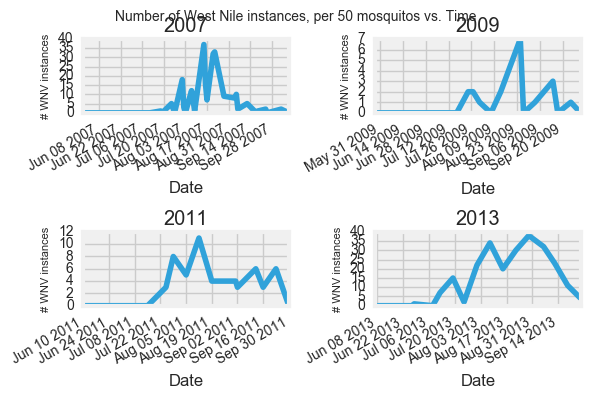

In [5]:
for i,(yr,_df) in enumerate(traindf.groupby('Yr')):
    plt.subplot(2,2,i+1)
    wnv_sum = _df.groupby('Date')['WnvPresent'].sum()
    wnv_sum.plot()
    plt.title(yr)
    plt.tight_layout()
    plt.ylabel("# WNV instances", size = 8)
_=plt.suptitle('Number of West Nile instances, per 50 mosquitos vs. Time')

Similarly, let's visualize how number of recorded mosquitoes varies with time:

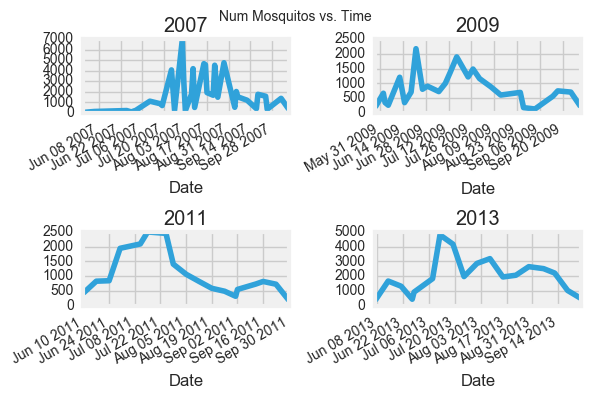

In [6]:
for i,(yr,_df) in enumerate(traindf.groupby('Yr')):
    plt.subplot(2,2,i+1)
    wnv_sum = _df.groupby('Date')['NumMosquitos'].sum()
    wnv_sum.plot()
    plt.title(yr)
    plt.tight_layout()
_=plt.suptitle('Num Mosquitos vs. Time')

In addition, we can visualize how our data varies geospatially:

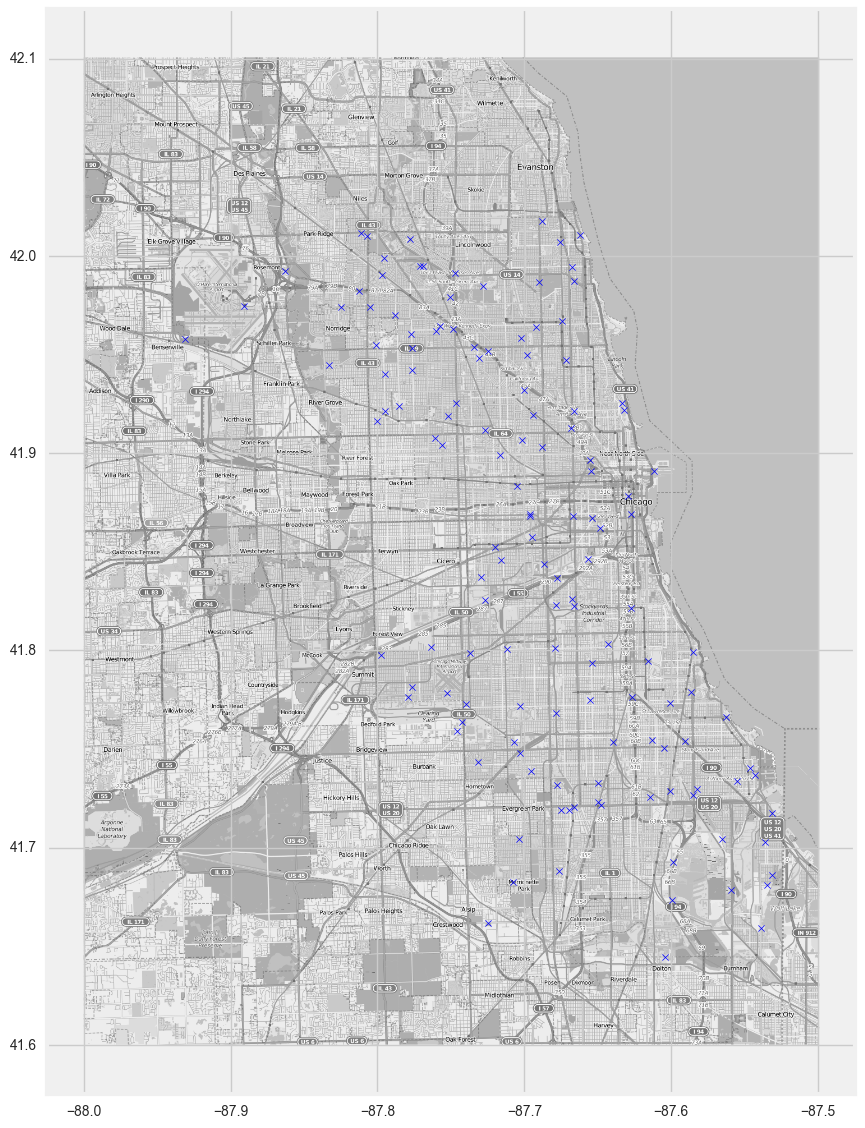

In [7]:
# Code snippet sourced from: https://www.kaggle.com/users/213536/vasco/predict-west-nile-virus/west-nile-heatmap
mapdata = np.loadtxt("../input/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('../input/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x')

I noticed stations with duplicate Lon/Lat combinations. This may be a data anomaly or perhaps a station was moved and the lon/lat changed. It doesn't affect a large portion of our data, so it shouldn't affect our final results much.

In [8]:
_ = traindf.groupby(['Trap','Longitude','Latitude'],as_index = False)
_.count().Trap.value_counts().head()

T035    2
T009    2
T230    1
T143    1
T160    1
Name: Trap, dtype: int64

In addition, let's see how frequent each mosquito species type is in our training dataset:

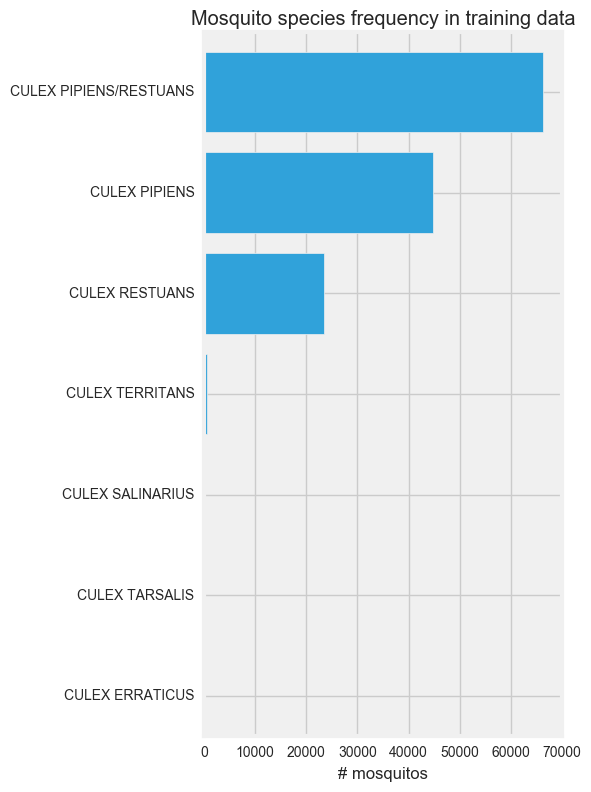

In [9]:
df = traindf.groupby('Species').aggregate({'NumMosquitos':'sum'})
vc = pd.Series(df.NumMosquitos).sort_values(ascending=False)
def plot_mosquito_freq(vc,**plotargs):
    fig = plt.figure(figsize = (6,8))
    ax = fig.add_subplot(111)
    loc = np.arange(len(vc))
    height = .8
    ax.barh(loc,vc[::-1], height = height,**plotargs)
    ax.set_yticks(loc + height/2)
    ax.set_yticklabels(vc.index[::-1])
    return ax
ax = plot_mosquito_freq(vc,**{'color':'#30a2da'})
plt.xlabel('# mosquitos')
plt.title('Mosquito species frequency in training data')
plt.tight_layout()
plt.savefig('../results/{}.png'.format(ax.get_title()))

It's also important to understand how species type and presence of WNV are related.

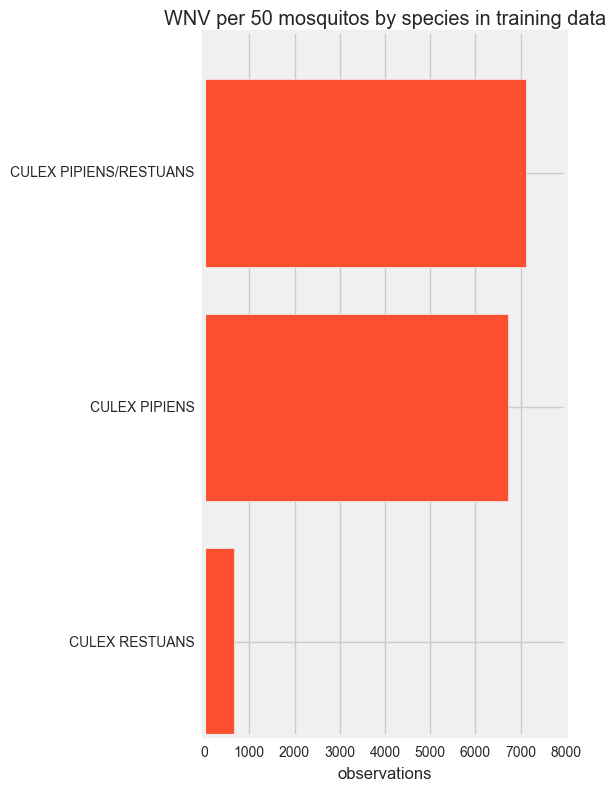

In [10]:
query_str = "WnvPresent == 1"
df = traindf.\
     query(query_str).\
     groupby('Species').\
     aggregate({'NumMosquitos':'sum'})
vc = pd.Series(df.NumMosquitos).sort_values(ascending=False)
ax = plot_mosquito_freq(vc,**{'color':'#fc4f30'})
plt.title('WNV per 50 mosquitos by species in training data')
plt.xlabel('observations')
plt.tight_layout()
plt.savefig('../results/{}.png'.format(ax.get_title()))

Clearly, we can observed that Culex Pipiens and Culex Restuans are the only two Species that we need to worry about for WNV.

After our initial exploration of the data, it is clear that time of the year and species may be powerful features for WNV prediction.

# Build a predictive model

Let's build an initial model for predicting when and which stations will have WNV present. Our model will be relatively simple using only 3 features: day of year, species, and trap ID. Firstly, we group our training data by day, trap, and species. This is necessary because of the manner in which the data was collected where traps with many mosquitos record measurements in 50 mosquito intervals. For training, we are interested in the presence of WNV at a given station, so we simply take the max of WNV in the group by. There are likely more clever approaches we could take to get at the extent of WNV for a given trap and day, but this approach is a good first pass.

In [11]:
_ = traindf.groupby(['Day','Trap','Species'])
df = _.aggregate({'WnvPresent':'max',
                  'Longitude':'max',
                  'Latitude':'max',
                  'Yr':'max',
                  'Date':'max'}) # can use max of lon/lat bc same for all stations
traindf_agg = df.reset_index()

yr = 2009
features = ['Day','Species','Trap']

In order to actually build and evaluate our model, we want to utilize K-Fold cross validation, where in each experiment the testing fold is a year of data and the training folds are the other 3 years of data. We will run 4 experiments in total, where we will build and evaluate a model in each experiment. This is an important step because it allows us to evaluate our model's performance in a manner that is similar to how it would be evaluated in real life. For example, the result of our cross validation will give us an estimate for how we expect our model to perform in the coming year of 2017.

<img src='../img/cv.png'></img>

In addition, we also need to transform our categorical variable, `species`, into dummy variables of 1s and 0s. This is standard practice for dealing with non-numeric data. Machine learning algorithms typically don't like strings, but they love numbers ;)

In [28]:
def year_experiment(df,test_yr,features):
    '''For k-fold cross validation,
    we want experiment to have a test fold of a given year
    and the training folds to be all over years.'''
    
    def get_fold_ix(df, test_yr):
        '''Needed to get indexes of training/testing folds'''
        test_fold = df.query('Yr == {test_yr}'.format(test_yr = test_yr))
        train_folds = df.query('Yr != {test_yr}'.format(test_yr = test_yr))
        return train_folds.index,test_fold.index
    
    def to_dummy(df, dummy_cl = None):
        '''We need to save our dummy classifier so we can apply
        it for testing, as well as training.'''
        if not dummy_cl:
            dummy_cl = DV()
        input_df = df.T.to_dict().values()
        dummy_cl.fit(input_df)
        res = dummy_cl.transform(input_df)
        df2 = pd.DataFrame(res.toarray().T,dummy_cl.feature_names_).T
        return df2, dummy_cl   

    train_ix,test_ix = get_fold_ix(df,test_yr)
    X = df[features]
    X,dummy_cl = to_dummy(X)
    y = df['WnvPresent']

    Xtrain,Xtest,ytrain,ytest = [X.iloc[train_ix],
                                 X.iloc[test_ix],
                                 y.iloc[train_ix],
                                 y.iloc[test_ix]]
    return (Xtrain,Xtest,ytrain,ytest), dummy_cl

Now that we have defined our function to split our data for each experiment, we can now run our K-Fold cross validation on all of the training data. We choose to run a Random Forest classifier with 1000 trees. This was chosen empirically as it achieved the highest area under the curve (AUC) of an [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) plot. AUC is a crucial tool for evaluating classification models. In this case AUC gives us an understanding of the trade-off between WNV identification *precision* and WNV identification *recall*. This concept of precision vs. recall is fundamental. It's so important it has its own [Wikipedia page](https://en.wikipedia.org/wiki/Precision_and_recall) ;)

In [59]:
aucs = []
for yr in [2007,2009,2011,2013]:
    (Xtrain,Xtest,ytrain,ytest), dummy_cl = year_experiment(traindf_agg,yr,features)
    cl = RandomForestClassifier(n_estimators=1000,n_jobs = -1)
    cl.fit(Xtrain,ytrain)
    yprob = cl.predict_proba(Xtest)[:,1]
    aucs.append((roc_auc_score(ytest, yprob)))
print(aucs)
print(np.mean(aucs))

[0.7473541420892843, 0.70452144263554728, 0.65171931746123246, 0.73927815630075611]
0.710718264622


We save all of the computed probabilities and test labels so we can build a ROC curve for each experiment:

AUC: 0.718821713544
AUC: 0.749795898766
AUC: 0.710958667205
AUC: 0.729829129336


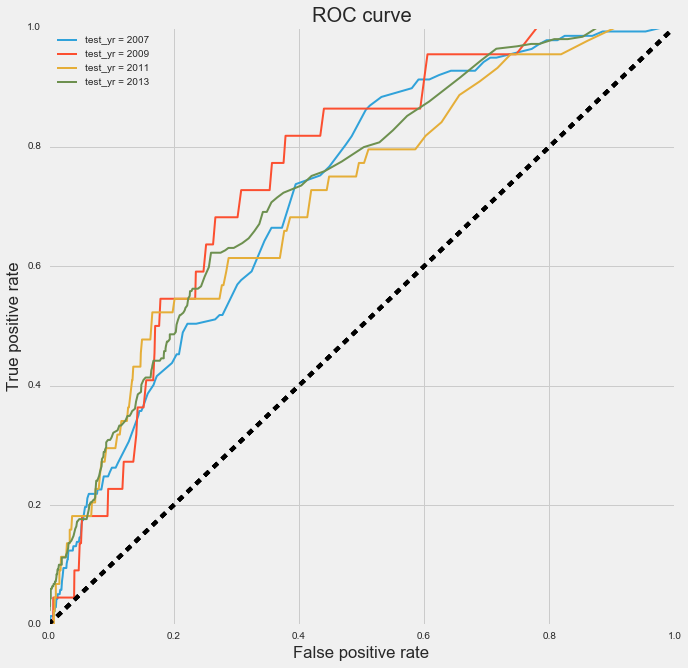

In [60]:
plt.figure(1,figsize=(10,10))
for (ytest,ypred_prob),yr in zip(zip(ytrues,yprobs),train_yrs):
    print "AUC: {}".format(roc_auc_score(ytest, ypred_prob))
    fpr, tpr, _ = roc_curve(ytest, ypred_prob)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, linewidth = 2,label = 'test_yr = {}'.format(yr))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
plt.savefig('../results/ROC_model1.png')

Our results are relatively stable across each experiment. In this case, true positive rate informs us how correct our model is when it predicts a given day-trap combination to have WNV. Recall, on the other hand, tells us how *many* of the total WNV instances we correctly predicted.

# Add weather data

We are also provided weather data, which is believed to have an important impact on WNV occurrence. Let's take a look.

In [12]:
weatherdf = pd.read_csv('../input/weather.csv').drop(['Station','CodeSum'],axis = 1)
# weatherdf['Date'] = pd.to_datetime(weatherdf['Date'])
# weatherdf['Year'] = weatherdf.Date.dt.year
# weatherdf['Day'] = weatherdf.Date.dt.dayofyear
weatherdf = cleanse_data(weatherdf)
weatherdf = weatherdf.set_index('Date')
weatherdf.head()

,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,...,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Yr,Day
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,83,50,67,14,51,56,0,2,0448,1849,...,M,0.0,0.00,29.10,29.82,1.7,27,9.2,2007,121
2007-05-01,84,52,68,M,51,57,0,3,-,-,...,M,M,0.00,29.18,29.82,2.7,25,9.6,2007,121
2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,...,M,0.0,0.00,29.38,30.09,13.0,4,13.4,2007,122
2007-05-02,60,43,52,M,42,47,13,0,-,-,...,M,M,0.00,29.44,30.08,13.3,2,13.4,2007,122
2007-05-03,66,46,56,2,40,48,9,0,0446,1851,...,M,0.0,0.00,29.39,30.12,11.7,7,11.9,2007,123


Let's compute a rolling average of weather. This will allow us to look at weather patterns in prior days for deriving features. For example, if we take a measurement on Thursday it seems reasonable that the weather on Monday, Tuesday, and Wednesday would affect the results of our measurement. We can capture this effect with a moving 3-day average.

In [14]:
def apply_rolling_window(weatherdf, WEATHER_FEATURES):
    '''Given our dataframe and the columns of interest, compute'''
    
    def fill_first_null(s):
        return s[~s.isnull()].iloc[0]
    
    _dfs = []
    for yr,_df in weatherdf.groupby('Year'):
        _df = _df[WEATHER_FEATURES].rolling(NDAYS).mean()
        for f in WEATHER_FEATURES:
            first_value = fill_first_null(_df[f])
            _df[f] = _df[f].fillna(first_value)
        _dfs.append(_df)
    df = pd.concat(_dfs)
    return df

def remove_whitespace(df):
    for c in df.select_dtypes(include=['object']):
        df[c] = df[c].str.strip()
    return df

In [15]:
_ = traindf.groupby(['Day','Trap','Species'])
df = _.aggregate({'WnvPresent':'max',
                  'Longitude':'max',
                  'Latitude':'max',
                  'Yr':'max',
                  'Date':'max'}) # can use max of lon/lat bc same for all stations
traindf_agg = df.reset_index()

weatherdf = pd.read_csv('../input/weather.csv').drop(['Station','CodeSum'],axis = 1)
weatherdf['Date'] = pd.to_datetime(weatherdf['Date'])
weatherdf['Year'] = weatherdf.Date.dt.year
weatherdf['Day'] = weatherdf.Date.dt.dayofyear
weatherdf = weatherdf.set_index('Date')

weatherdf = remove_whitespace(weatherdf)
weatherdf = weatherdf.replace(r'^[^\d.]+$', 0, regex=True)
for c in weatherdf.columns:
    weatherdf[c] = pd.to_numeric(weatherdf[c])
weatherdf = weatherdf.reset_index()

weatherdf = weatherdf.groupby('Date',as_index = False).mean()

In [17]:
weatherdf.Tmin

0       51.0
1       42.5
2       47.0
3       50.0
4       53.5
5       50.5
6       48.5
7       57.0
8       62.0
9       57.5
10      50.0
11      46.5
12      43.5
13      55.0
14      56.5
15      44.5
16      43.5
17      42.5
18      56.0
19      43.5
20      45.0
21      57.5
22      63.0
23      64.5
24      56.5
25      49.5
26      58.0
27      52.0
28      62.5
29      68.0
        ... 
1442    64.5
1443    44.5
1444    36.0
1445    39.5
1446    45.0
1447    48.5
1448    46.0
1449    46.5
1450    41.5
1451    38.0
1452    41.5
1453    57.5
1454    53.0
1455    51.5
1456    51.5
1457    48.5
1458    37.5
1459    34.5
1460    48.0
1461    47.0
1462    39.0
1463    38.5
1464    53.0
1465    50.5
1466    43.0
1467    52.5
1468    46.5
1469    38.0
1470    34.5
1471    33.5
Name: Tmin, dtype: float64

In [26]:
# weather
WEATHER_FEATURES = weatherdf.drop(['Date','Year','Day'], axis = 1).columns.tolist()

# NDAYS = 30
for n in [3,5,7]:
# for n in [3]:
    NDAYS = n
    FEATURES_ROLLING = ['{}_rolling{}'.format(f,NDAYS) for f in WEATHER_FEATURES]
    weatherdf[FEATURES_ROLLING] = apply_rolling_window(weatherdf, WEATHER_FEATURES) 
    
# merge weather with other other data
df_merge = traindf_agg.merge(weatherdf,on = 'Date',how='inner')

## Plot Weather

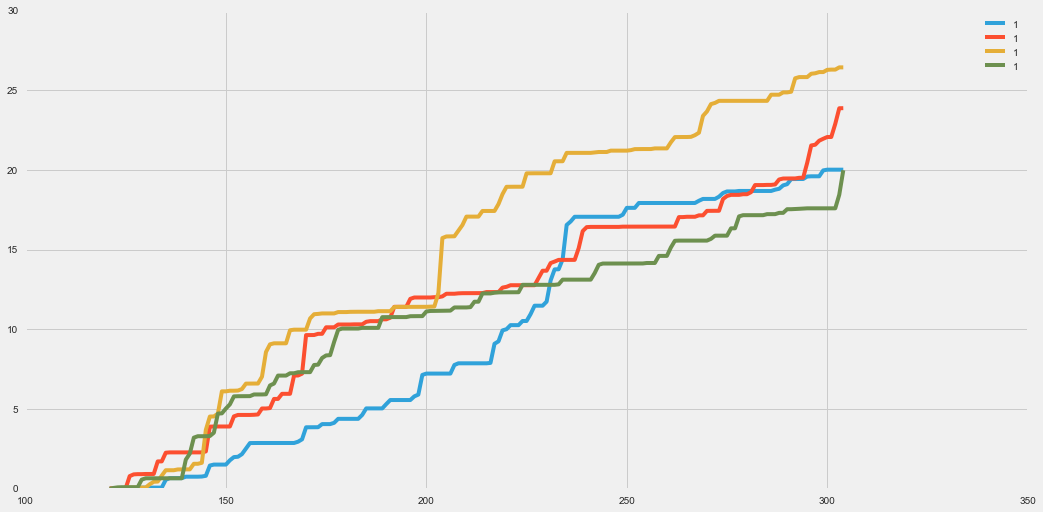

In [21]:
for yr in (2007,2009,2011,2013):
    weather2 = weatherdf[weatherdf.Date.dt.year == yr]
    plt.plot(weather2.Day,weather2.PrecipTotal.cumsum(),label = 1)
plt.legend()

AttributeError: 'DataFrame' object has no attribute 'Tavg_rolling7'

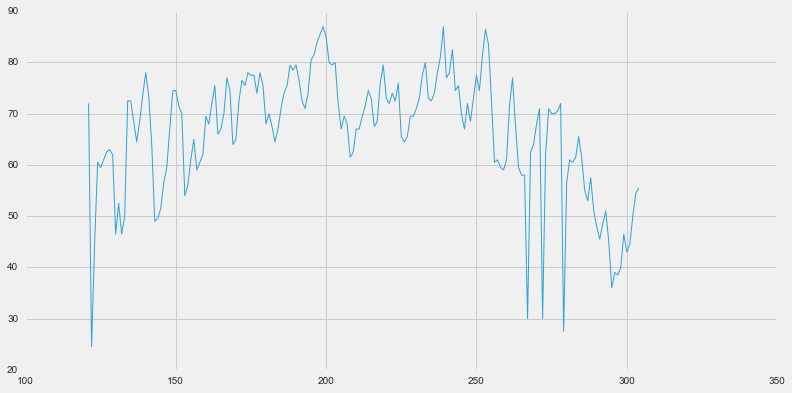

In [22]:
plt.figure(figsize = (12,6))
plt.plot(weather2.Date.dt.dayofyear,weather2.Tavg,linewidth = 1,label = 2013)
plt.plot(weather2.Date.dt.dayofyear,weather2.Tavg_rolling7,linewidth = 3,label = '7 day average')
plt.xlabel('Day of year')
plt.ylabel('Average temp (F)')
plt.legend()
plt.title('Average temperature, 2013')
plt.tight_layout()
plt.savefig('../results/2013_avg_temp.png')

In [29]:
FEATURES = df_merge.drop(['Date','WnvPresent','Longitude','Latitude'], axis = 1).columns.tolist()
aucs = []
ytrues,yprobs = [],[]
train_yrs = [2007,2009,2011,2013]
for yr in train_yrs:
    (Xtrain,Xtest,ytrain,ytest), dummy_cl = year_experiment(df_merge,yr,FEATURES)
    cl = RandomForestClassifier(n_estimators=1000,n_jobs = -1)
#     cl = LogisticRegression()
    cl.fit(Xtrain,ytrain)
    yprob = cl.predict_proba(Xtest)[:,1]
    ytrues.append(ytest.values)
    yprobs.append(yprob)
    aucs.append((roc_auc_score(ytest, yprob)))
print(aucs)
print(np.mean(aucs))

[0.67259016995366139, 0.74420112375738356, 0.71621173689975215, 0.74882627503775723]
0.720457326412


AUC: 0.718821713544
AUC: 0.749795898766
AUC: 0.710958667205
AUC: 0.729829129336


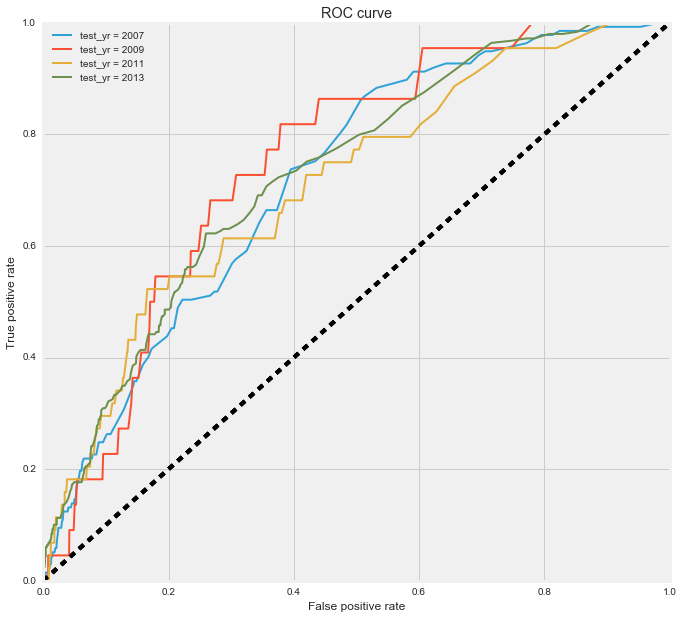

In [31]:
plt.figure(1,figsize=(10,10))
for (ytest,ypred_prob),yr in zip(zip(ytrues,yprobs),train_yrs):
    print "AUC: {}".format(roc_auc_score(ytest, ypred_prob))
    fpr, tpr, _ = roc_curve(ytest, ypred_prob)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, linewidth = 2,label = 'test_yr = {}'.format(yr))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
plt.savefig('../results/ROC.png')

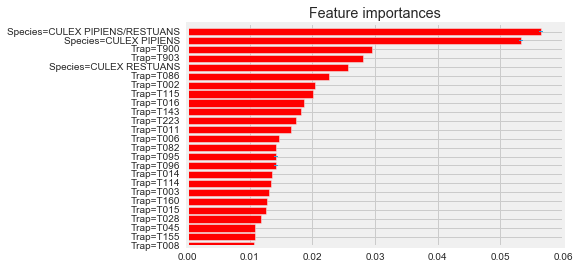

In [32]:
X = Xtrain
importances = cl.feature_importances_
std = np.std([tree.feature_importances_ for tree in cl.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(Xtrain.shape[1])[::-1], importances[indices],
       color="r", yerr=std[indices], align="center")
plt.yticks(range(Xtrain.shape[1])[::-1], X.columns[indices])
plt.ylim([Xtrain.shape[1] - 25, Xtrain.shape[1]])
plt.show()

# Apply to test data for submission
Train and test for testing

In [39]:
df = df_merge
FEATURES = df_merge.drop(['Date','Year','Yr','Day_x','Day_y','WnvPresent','Longitude','Latitude'], axis = 1).columns.tolist()
features = FEATURES

# test/train split 
X = df[features]

# dummy 
dummy_cl = DV()
input_df = X.T.to_dict().values()
dummy_cl.fit(input_df)
df_dummy = dummy_cl.transform(input_df)

# back to df
X = pd.DataFrame(df_dummy.toarray().T,dummy_cl.feature_names_).T

y = df.WnvPresent

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y)
cl = RandomForestClassifier(n_estimators=1000,n_jobs=-1)
cl.fit(Xtrain, ytrain)

# build model
cl = RandomForestClassifier(n_estimators=1000,n_jobs=-1)
cl.fit(X, y)
yprob = cl.predict_proba(X)[:,1]
roc_auc_score(y,yprob)

1.0

In [59]:
Xtrain

,AvgSpeed,AvgSpeed_rolling3,AvgSpeed_rolling3_rolling3,AvgSpeed_rolling3_rolling5,AvgSpeed_rolling3_rolling7,AvgSpeed_rolling5,AvgSpeed_rolling5_rolling3,AvgSpeed_rolling5_rolling5,AvgSpeed_rolling5_rolling7,AvgSpeed_rolling7,...,WetBulb_rolling5,WetBulb_rolling5_rolling3,WetBulb_rolling5_rolling5,WetBulb_rolling5_rolling7,WetBulb_rolling7,WetBulb_rolling7_rolling3,WetBulb_rolling7_rolling5,WetBulb_rolling7_rolling7,Year,Yr
0,8.20,7.750000,8.533333,8.706667,9.264286,8.86,8.706667,9.284,9.865714,8.650000,...,55.5,55.433333,55.50,55.371429,55.500000,55.761905,55.371429,54.428571,2009.0,2009.0
1,8.20,7.750000,8.533333,8.706667,9.264286,8.86,8.706667,9.284,9.865714,8.650000,...,55.5,55.433333,55.50,55.371429,55.500000,55.761905,55.371429,54.428571,2009.0,2009.0
2,8.20,7.750000,8.533333,8.706667,9.264286,8.86,8.706667,9.284,9.865714,8.650000,...,55.5,55.433333,55.50,55.371429,55.500000,55.761905,55.371429,54.428571,2009.0,2009.0
3,8.20,7.750000,8.533333,8.706667,9.264286,8.86,8.706667,9.284,9.865714,8.650000,...,55.5,55.433333,55.50,55.371429,55.500000,55.761905,55.371429,54.428571,2009.0,2009.0
4,8.20,7.750000,8.533333,8.706667,9.264286,8.86,8.706667,9.284,9.865714,8.650000,...,55.5,55.433333,55.50,55.371429,55.500000,55.761905,55.371429,54.428571,2009.0,2009.0
5,8.20,7.750000,8.533333,8.706667,9.264286,8.86,8.706667,9.284,9.865714,8.650000,...,55.5,55.433333,55.50,55.371429,55.500000,55.761905,55.371429,54.428571,2009.0,2009.0
6,8.20,7.750000,8.533333,8.706667,9.264286,8.86,8.706667,9.284,9.865714,8.650000,...,55.5,55.433333,55.50,55.371429,55.500000,55.761905,55.371429,54.428571,2009.0,2009.0
7,8.20,7.750000,8.533333,8.706667,9.264286,8.86,8.706667,9.284,9.865714,8.650000,...,55.5,55.433333,55.50,55.371429,55.500000,55.761905,55.371429,54.428571,2009.0,2009.0
8,8.20,7.750000,8.533333,8.706667,9.264286,8.86,8.706667,9.284,9.865714,8.650000,...,55.5,55.433333,55.50,55.371429,55.500000,55.761905,55.371429,54.428571,2009.0,2009.0
9,8.20,7.750000,8.533333,8.706667,9.264286,8.86,8.706667,9.284,9.865714,8.650000,...,55.5,55.433333,55.50,55.371429,55.500000,55.761905,55.371429,54.428571,2009.0,2009.0


In [58]:
FEATURES = df_merge.drop(['Date','WnvPresent'], axis = 1).columns.tolist()
aucs = []
ytrues,yprobs = [],[]
for yr in [2007,2009,2011,2013]:
    (Xtrain,Xtest,ytrain,ytest), dummy_cl = year_experiment(df_merge,yr,FEATURES)
    cl = RandomForestClassifier(n_estimators=1000,n_jobs = -1)
#     cl = LogisticRegression()
    cl.fit(Xtrain,ytrain)
    yprob = cl.predict_proba(Xtest)[:,1]
    ytrues.append(ytest)
    yprobs.append(yprob)
    aucs.append((roc_auc_score(ytest, yprob)))
print(aucs)
print(np.mean(aucs))

[0.71134225655217442, 0.73328771070450949, 0.75551248054418629, 0.72299749195306473]
0.730784984938


In [ ]:
importances = cl.feature_importances_
std = np.std([tree.feature_importances_ for tree in cl.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.ylim([-1, 25])
plt.show()

In [ ]:
testdf.cnt.value_counts()

In [ ]:
TEST_df_merge = testdf.merge(weatherdf,on = 'Date',how='inner')
# do on test set

input_df = TEST_df_merge[features].T.to_dict().values()
res = dummy_cl.transform(input_df)
X = pd.DataFrame(res.toarray().T,dummy_cl.feature_names_).T

# X = testdf[features]
# X['Species'] = le1.transform(X['Species'].values)
# X['Trap']    = le2.transform(X['Trap'].values)

# 
TEST_PRED = cl.predict_proba(X)[:,1]
s = pd.Series(TEST_PRED)
s.index += 1
s.name = 'WnvPresent'
s.to_csv('../results/test_submission_v7.csv', index_label = "Id", header = True)

In [ ]:
X.columns

In [ ]:
_ = testdf.groupby(['Day','Trap','Species'])
df2 = _.aggregate({'Longitude':'max',
                  'Latitude':'max',
                  'Yr':'max'}) # can use max of lon/lat bc same for all stations
df2 = df2.reset_index()
df2.shape

In [ ]:
from sklearn.pipeline import Pipeline
cl_pipeline = Pipeline([('dummy',dummy_cl),
                        ('model',cl)])
input_df = testdf[features].T.to_dict().values()
pred = cl_pipeline.predict(input_df)

In [ ]:
s = pd.Series(pred)
s.index += 1
s.to_csv('../results/test_submission_v0.csv')